# Calibration

In [1]:
import numpy as np
import pandas as pd
import numpy as np
from os.path import join
import json

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

# custom functions to run the calibration simulations
import calibration_functions as cf

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

## Empirical outbreak data

In [3]:
empirical_data_src = '../../data/school_data/empirical_observations/'

# distribution of outbreak sizes by school type
outbreak_sizes = pd.read_csv(\
            join(empirical_data_src, 'empirical_outbreak_sizes.csv'))
# ratio of infections in the student and teacher groups
group_distributions = pd.read_csv(\
            join(empirical_data_src, 'empirical_group_distributions.csv'))

In [4]:
# note: these are the number of clusters per school type from the slightly older
# data version (November 2020). 
counts = pd.DataFrame({'type':['upper_secondary', 'secondary'],
                      'count':[116, 70]})

counts.index = counts['type']
counts = counts.drop(columns=['type'])
# The cluster counts are used to weigh the respective school type in the 
# calibration process.
counts['weight'] = counts['count'] / counts['count'].sum()

## Re-run the school calibration

In [ ]:
# List of prevention measures that were in place in schools in the weeks 36-45
# of the year 2020 in Austrian schools. This list was compiled from information
# collected in interviews with teachers of different school types. NOTE: so far
# there are no recorded differences between school types.
with open('params/calibration_measures.json', 'r') as fp:
    prevention_measures = json.load(fp)
# simulation parameters, specifically the
# - base transmission risk (calibrated from household transmissions)
# - subclinical transmission modifier (literature value)
# - exposure duration, time until symtpoms and infection duration (lit. values)
# - age symptom discount (fit to empirical observations)
with open('params/calibration_simulation_parameters.json', 'r') as fp:
    simulation_params = json.load(fp)
# characteristics (# classes, # students / class, # teachers) of the "average" 
# school, depending on school type. These characteristics were determined in 
# interviews with Austrian teachers and from statistics about Austrian schools 
# (year 2017/18, page 10: https://www.bmbwf.gv.at/Themen/schule/schulsystem/gd.html)
# NOTE: "students" indicates the number of students per class
with open('params/calibration_school_characteristics.json', 'r') as fp:
    school_characteristics = json.load(fp)

## Simulation data

### Simulation parameters

In [17]:
# school types over which the calibration was run
school_types = ['upper_secondary', 'secondary']

# the way the simulation framework is set up, it works with a "base transmission risk"
# for a household contact, that is then multiplied by a modifier for a different contact
# setting. What we calibrate is this modifier.
base_transmission_risk = 0.16598

transmission_risk_modifier = np.asarray([0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29,
                     0.30, 0.31, 0.32, 0.33, 0.34, 0.35])

# For the school simulations, we also calibrated a modifier for student age
# (the "age transmission discount"). The calibration showed no age dependence
# but since we re-use data from the calibration that was done for the school
# simulations, we carry these parameter values with us and use them to access
# the simulation result files.

# The age_transmission_discount sets the slope of the age-dependence of the 
# transmission risk. Transmission risk for adults (age 18+) is always base 
# transmission risk. For every year an agent is younger than 18 years, the
# transmission risk is reduced. Parameter values are chosen around the optimum 
# from the previous random sampling search
age_transmission_discounts = [0.00, -0.0025, -0.005, -0.0075, -0.01,
                                   -0.0125, -0.015, -0.0175, -0.02,
                                   -0.0225, -0.025, -0.0275, -0.03]

# list of all possible parameter combinations from the grid
screening_params = [(i, j, j, k) for i in school_types \
                    for j in transmission_risk_modifier \
                    for k in age_transmission_discounts]


print('values for the base transmission risk rescaled by the modifier [%]:')
print(transmission_risk_modifier * base_transmission_risk * 100)
print()
print('parameter value step rescaled by the modifier [%]: {:1.2f}'\
      .format(transmission_risk_modifier[1] * base_transmission_risk * 100 -\
              transmission_risk_modifier[0] * base_transmission_risk * 100))

values for the base transmission risk rescaled by the modifier [%]:
[3.81754 3.98352 4.1495  4.31548 4.48146 4.64744 4.81342 4.9794  5.14538
 5.31136 5.47734 5.64332 5.8093 ]

parameter value step rescaled by the modifier [%]: 0.17


### Load data for upper secondary and secondary schools

In [18]:
# calculate the various distribution distances between the simulated and
# observed outbreak size distributions
src = '../../data/school_data/simulation_results'

results_fine = pd.DataFrame()
for i, ep in enumerate(screening_params):
    school_type, icw, fcw, atd = ep
    if i % 100 == 0:
        print('{}/{}'.format(i, len(screening_params)))
    fname = 'school_type-{}_icw-{:1.2f}_fcw-{:1.2f}_atd-{:1.4f}_infected.csv'\
        .format(school_type, icw, fcw, atd)
    ensemble_results = pd.read_csv(join(src, fname), 
            dtype={'infected_students':int, 'infected_teachers':int,
                   'infected_total':int, 'run':int})
    row = cf.calculate_distances(ensemble_results, school_type, icw, fcw, atd,
                       outbreak_sizes, group_distributions)
    
    results_fine = results_fine.append(row, ignore_index=True)

0/338
100/338
200/338
300/338


In [6]:
print('number of runs per ensemble: {}'.format(len(ensemble_results))) 

number of runs per ensemble: 4000


## Calculate distances between empirical and simulated data

In [19]:
# collection of different distance metrics to try
distance_cols = [
    'sum_of_squares',
    'chi2_distance',
    'bhattacharyya_distance',
    'spearmanr_difference',
    'pearsonr_difference',
    'pp_difference',
    'qq_difference',
]

In [20]:
results_fine = results_fine.sort_values(by=['school_type',
                'intermediate_contact_weight', 'age_transmission_discount'])
results_fine = results_fine.reset_index(drop=True)

for col in distance_cols:
    results_fine[col + '_total'] = results_fine[col + '_size'] + \
                    results_fine['sum_of_squares_distro']
    results_fine[col + '_total_weighted'] = results_fine[col + '_total']
    
    for i, row in results_fine.iterrows():
        st = row['school_type']
        weight = counts.loc[st, 'weight']
        error = row[col + '_total']
        results_fine.loc[i, col + '_total_weighted'] = error * weight

## Find optimal parameter values

In [21]:
agg_results_fine = results_fine\
    .drop(columns=['far_contact_weight'])\
    .rename(columns={'intermediate_contact_weight':'contact_weight'})\
    .groupby(['contact_weight',
              'age_transmission_discount'])\
    .sum()

for col in distance_cols:
    print(col)
    opt_fine = agg_results_fine.loc[\
            agg_results_fine[col + '_total_weighted'].idxmin()].name
    opt_contact_weight_fine = opt_fine[0]
    opt_age_transmission_discount_fine = opt_fine[1]

    print('optimal grid search parameter combination:')
    print('\t contact weight: {:1.3f}'\
          .format(opt_contact_weight_fine))
    print('\t age transmission discount: {:1.4f}'\
          .format(opt_age_transmission_discount_fine))
    print()

sum_of_squares
optimal grid search parameter combination:
	 contact weight: 0.260
	 age transmission discount: 0.0000

chi2_distance
optimal grid search parameter combination:
	 contact weight: 0.260
	 age transmission discount: 0.0000

bhattacharyya_distance
optimal grid search parameter combination:
	 contact weight: 0.240
	 age transmission discount: -0.0300

spearmanr_difference
optimal grid search parameter combination:
	 contact weight: 0.230
	 age transmission discount: -0.0075

pearsonr_difference
optimal grid search parameter combination:
	 contact weight: 0.250
	 age transmission discount: 0.0000

pp_difference
optimal grid search parameter combination:
	 contact weight: 0.240
	 age transmission discount: -0.0050

qq_difference
optimal grid search parameter combination:
	 contact weight: 0.320
	 age transmission discount: -0.0225



## Visualise distances

In [22]:
# compose matrices of the distance measurements for all different distance
# metrics which are calculated as sum between the first component (ratio of
# infected students and teachers) and the second component (outbreak size
# distribution)
distance_images = {}
for col in distance_cols:
    img_fine = np.zeros((len(contact_weights_fine),
                    len(age_transmission_discounts_fine)))
    for i, cw in enumerate(contact_weights_fine):
        for j, atd in enumerate(age_transmission_discounts_fine):
            cw = round(cw, 2)
            atd = round(atd, 4)
            try:
                img_fine[i, j] = agg_results_fine\
                    .loc[cw, atd][col + '_total_weighted']
            except KeyError:
                print(atd)
                img_fine[i, j] = np.nan
    distance_images[col] = img_fine

In [23]:
# qq and spearman are super noisy, exclude them for further analysis
distance_col_names = {
    'sum_of_squares':'Sum of squares',
    'chi2_distance':'$\\chi^2$',
    'bhattacharyya_distance':'Bhattacharyya',
    'spearmanr_difference': 'Spearman correlation',
    'pearsonr_difference':'Pearson correlation',
    'pp_difference':'pp-slope',
    'qq_difference':'qq-slope'
}

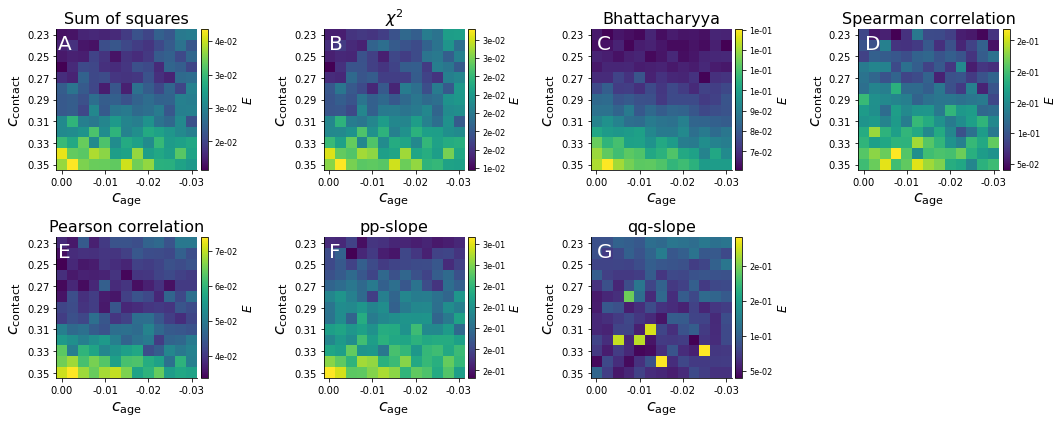

In [24]:
fig, axes = plt.subplots(2, 4, figsize=(15, 6))

for ax, col in zip(axes.flatten(), distance_col_names.keys()):
    img_fine = distance_images[col]
    im = ax.imshow(img_fine)
    ax.set_yticks(range(len(contact_weights_fine))[::2])
    ax.set_yticklabels(['{:1.2f}'.format(cw) for \
                        cw in contact_weights_fine[::2]])
    #ax.set_xticks(range(len(age_transmission_discounts_fine))[::2])
    ax.set_xticks([0, 4, 8, 12])
    ax.set_xticklabels(['0.00', '-0.01', '-0.02', '-0.03'])
    #ax.set_xticklabels(['{:1.4f}'.format(atd) for \
    #                    atd in age_transmission_discounts_fine[::2]],
    #                    fontsize=8)
    ax.set_title(distance_col_names[col], fontsize=16)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical', format='%.0e')
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label('$E$', fontsize=12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylabel('$c_\\mathrm{contact}$', fontsize=16)
    ax.set_xlabel('$c_\\mathrm{age}$', fontsize=16)

axes[1, 3].axis('off')

fig.text(0.061, 0.875, 'A', color='w', fontsize=20)
fig.text(0.312, 0.875, 'B', color='w', fontsize=20)
fig.text(0.56, 0.875, 'C', color='w', fontsize=20)
fig.text(0.808, 0.875, 'D', color='w', fontsize=20)
fig.text(0.061, 0.395, 'E', color='w', fontsize=20)
fig.text(0.312, 0.395, 'F', color='w', fontsize=20)
fig.text(0.56, 0.395, 'G', color='w', fontsize=20)

fig.tight_layout()

## Confidence intervals for the optimum values

In [30]:
def run_bootstrap(params):
    src = '../../data/calibration/simulation_results/ensembles_fine_ensemble_distributions'
    ensemble_results, st, icw, fcw, atd, outbreak_sizes, \
    group_distributions, bootstrap_run = params
    
    row = cf.calculate_distances(ensemble_results, st, icw, fcw, atd,
                       outbreak_sizes, group_distributions)
    
    row.update({'bootstrap_run':bootstrap_run})
    
    return row

In [ ]:
# calculate the various distribution distances between the simulated and
# observed outbreak size distributions. Note: 

dst = '../../data/school_data/simulation_results/'
N_bootstrap = 1000 # number of subsamplings per parameter combination
number_of_cores = 10

bootstrapping_results = pd.DataFrame()
for i, ep in enumerate(screening_params):
    school_type, icw, fcw, atd = ep
    if i % 100 == 0:
        print('{}/{}'.format(i, len(screening_params)))
        
    fname = 'school_type-{}_icw-{:1.2f}_fcw-{:1.2f}_atd-{:1.4f}_infected.csv'\
        .format(school_type, icw, fcw, atd)
    ensemble_results = pd.read_csv(join(src, fname), 
            dtype={'infected_students':int, 'infected_teachers':int,
                   'infected_total':int, 'run':int})
    
    bootstrap_params = [(ensemble_results.sample(2000), school_type, icw, fcw, \
                        atd, outbreak_sizes, group_distributions, j) \
                        for j in range(N_bootstrap)]
    
    number_of_cores = number_of_cores = psutil.cpu_count(logical=True) - 2
    pool = Pool(number_of_cores)

    for res in tqdm(pool.imap_unordered(func=run_bootstrap,
                    iterable=bootstrap_params), total=len(bootstrap_params)):
        bootstrapping_results = bootstrapping_results\
            .append(res, ignore_index=True)
    
bootstrapping_results.to_csv(join(dst, 'bootstrapping_results_{}.csv'\
                                .format(N_bootstrap)), index=False)

In [32]:
dst = '../../data/school_data/simulation_results/'
N_bootstrap = 1000
bs_results = pd.read_csv(join(dst, 'bootstrapping_results_{}.csv'\
                                .format(N_bootstrap)))
bs_results = bs_results\
    .rename(columns={'intermediate_contact_weight':'contact_weight'})\
    .drop(columns=['far_contact_weight'])

# calculated the weighted sum of error terms for all distance measures
for col in distance_cols:
    bs_results[col + '_total'] = \
        bs_results[col + '_size'] + bs_results['sum_of_squares_distro']
    bs_results[col + '_total_weighted'] = bs_results[col + '_total']
        
    for st in school_types:
        weight = counts.loc[st, 'weight']
        st_indices = bs_results[bs_results['school_type'] == st].index
        bs_results.loc[st_indices, col + '_total_weighted'] = \
            bs_results.loc[st_indices, col + '_total'] * weight

In [33]:
agg_bs_results = bs_results\
    .groupby(['contact_weight',
              'age_transmission_discount',
              'bootstrap_run'])\
    .sum()

In [34]:
opt_bs = pd.DataFrame()
for i in range(N_bootstrap):
    run_data = agg_bs_results.loc[:, :, i]
    row = {'bootstrap_run':i}
    for col in distance_cols:
        opt = run_data.loc[\
                run_data[col + '_total_weighted'].idxmin()].name
        opt_contact_weight_bs = opt[0]
        opt_age_transmission_discount_bs = opt[1]
        row.update({
            'contact_weight_' + col:opt_contact_weight_bs,
            'age_transmission_discount_' + col:opt_age_transmission_discount_bs
        })

    opt_bs = opt_bs.append(row, ignore_index=True)

In [39]:
uncertainties_cw = []
medians_cw = []
uncertainties_atd = []
medians_atd = []
for col in distance_cols:
    median = opt_bs['contact_weight_' + col].median() * base_transmission_risk
    mean = opt_bs['contact_weight_' + col].mean() * base_transmission_risk
    low = opt_bs['contact_weight_' + col].quantile(0.025) * base_transmission_risk
    high = opt_bs['contact_weight_' + col].quantile(0.975) * base_transmission_risk
    
    atd_median = opt_bs['age_transmission_discount_' + col].median()
    atd_mean = opt_bs['age_transmission_discount_' + col].mean()
    atd_low = opt_bs['age_transmission_discount_' + col].quantile(0.025)
    atd_high = opt_bs['age_transmission_discount_' + col].quantile(0.975)
    
    print('{}: contact weight {} [{}; {}] (mean {:1.4f}), atd {} [{}; {}]'\
          .format(col, median, low, high, mean, atd_median, atd_low, atd_high, atd_mean))
    
    uncertainties_cw.append(high - low)
    uncertainties_atd.append(atd_high - atd_low)
    medians_cw.append(median)
    medians_atd.append(atd_median)

sum_of_squares: contact weight 0.041495 [0.0381754; 0.0464744] (mean 0.0416), atd -0.0025 [-0.0225; 0.0]
chi2_distance: contact weight 0.0431548 [0.0381754; 0.0464744] (mean 0.0423), atd 0.0 [-0.015; 0.0]
bhattacharyya_distance: contact weight 0.039835199999999994 [0.0381754; 0.0448146] (mean 0.0406), atd -0.02 [-0.03; 0.0]
spearmanr_difference: contact weight 0.0381754 [0.0381754; 0.041495] (mean 0.0389), atd -0.025 [-0.03; -0.0025]
pearsonr_difference: contact weight 0.0448146 [0.039835199999999994; 0.048134199999999995] (mean 0.0439), atd -0.005 [-0.025; 0.0]
pp_difference: contact weight 0.039835199999999994 [0.0381754; 0.041495] (mean 0.0392), atd -0.0075 [-0.03; -0.0025]
qq_difference: contact weight 0.0547734 [0.048134199999999995; 0.05809299999999999] (mean 0.0547), atd -0.0075 [-0.0225; 0.0]
